# `analyze_optogenetics_pulsed_red.ipynb`

Plots results from R19G10>CsChrimson optogenetics experiment, in which flies experienced 30 seconds of 5 ms 5 Hz pulses of red light, followed by ~65 seconds of darkness. Creates Figure 2-S2 E-F.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import array
import os
import pandas as pd
from mpl_toolkits import mplot3d
from matplotlib.lines import Line2D
from scipy.io import loadmat
import seaborn as sns
from scipy.stats import gaussian_kde

def set_font_sizes(SMALL_SIZE=14, MEDIUM_SIZE=16, LARGE_SIZE=20):
    '''
    Sets font size for matplotlib
    From: https://stackoverflow.com/a/39566040
    '''
    font = {'family':'sans-serif',
            'sans-serif':['Arial'],
            'size': SMALL_SIZE}
    plt.rc('font', **font)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title
    
set_font_sizes()

def read_margo_binary_file(bin_file, MAX_N_FRAMES=int(1e9)):
    try:
        my_array = array.array("f")
        my_array.fromfile(open(bin_file, mode='rb'), MAX_N_FRAMES)
        # this is a trick! Let n be large, like the max number of frames. Then,
        # array.fromfile will read in up to n items. if n exceeds the number
        # of items in the actual file, a warning gets raised, but it'll still
        # load in the real number of items... so to suppress the warning, I
        # put this in a try: except and just return the object loaded with
        # however true items there are inside.
    except EOFError:
        my_array = np.array(my_array)
        
    return my_array 

## define experimental conditions

In [2]:
ATR_minus_is = np.array([1,3,5,7,
                         10,12,14,16,
                         17,19,21,23,
                         26,28,30,32,
                         33,35,37,39,#35,37,#33,35,37,39,
                         42,44,46,48
                        ]) - 1

ATR_plus_is = np.array([2,4,6,8,
                       9,11,13,15,
                       18,20,22,24,
                       25,27,29,31,
                       34,36,38,40,
                       41,43,45,47]) - 1

cond_is = [ATR_minus_is, ATR_plus_is]

cond_names = ['R19G10 > CsChr (ATR -)', 
              'R19G10 > CsChr (ATR +)']

def i_to_cond(i):
    if i in ATR_minus_is:
        return 0
    elif i in ATR_plus_is:
        return 1
    return 100

## read in tracking data

MARGO was used for tracking centroids of 48 animals in circular arenas.

In [3]:
margo_dir = '../../Data/Data by figure/Fig 2 + Supp/CsChrimson/09-30-2022-10-39-38__Basic_Tracking_R19G10CsChr_1-48_Day1/'
margo_raw_data_dir = os.path.join(margo_dir, 'raw_data/')

margo_bin_files = [os.path.join(margo_raw_data_dir, x) for x in os.listdir(margo_raw_data_dir)]

t_file = [x for x in margo_bin_files if '__time' in x][0]
time_diff_array = read_margo_binary_file(t_file)
cum_time = np.cumsum(time_diff_array)

t_file = [x for x in margo_bin_files if '__time' in x][0]
centroid_file = [x for x in margo_bin_files if '__centroid' in x][0]

time_diff_array = read_margo_binary_file(t_file)
raw_centroid_array = read_margo_binary_file(centroid_file)


nT = len(time_diff_array)

time_array = np.cumsum(time_diff_array) / 60

nROI = len(raw_centroid_array) / 2 / nT
nROI = int(nROI)

raw_centroid_array = raw_centroid_array.reshape((nT,2,nROI))
raw_centroid_array.shape

(45487, 2, 48)

## read in red light on/off status

A MATLAB program was used to flash a white screen at the desired frequency/duration (5 ms 5 Hz for 30 seconds) on a computer whose display was projected onto the behavioral arenas through a red filter. For the duration of each 30 second light flashing stimulus, the MATLAB program also turned on an IR LED mounted inside the tracking box, and turned off the LED upon conclusion of the 30 second flashing. Thus, the times in the tracking data in which the flies see red light could be obtained by recording the on/off times in the recorded video of the IR LED. The next cells read in the IR LED transitions by running red_light_from_IR_LED.py

In [4]:
df_IR_LED = pd.read_csv(os.path.join(margo_dir, 'IR_sensor', 'IR_intensity.csv'), index_col=0)
IR_LED_onoff = df_IR_LED['IR_LED_on'].values

IR_on_to_off_indices = []
IR_off_to_on_indices = []
for i in range(1,nT):
    if (IR_LED_onoff[i-1] == 0) & (IR_LED_onoff[i] == 1):
        IR_off_to_on_indices.append(i)
    elif (IR_LED_onoff[i-1] == 1) & (IR_LED_onoff[i] == 0):
        IR_on_to_off_indices.append(i)
        
IR_on_to_off_indices = np.array(IR_on_to_off_indices)
IR_off_to_on_indices = np.array(IR_off_to_on_indices)

t_is_in_red = IR_LED_onoff

In [5]:
c_red_on = np.array(['k'] * len(t_is_in_red))
c_red_on[t_is_in_red == 1] = 'r'

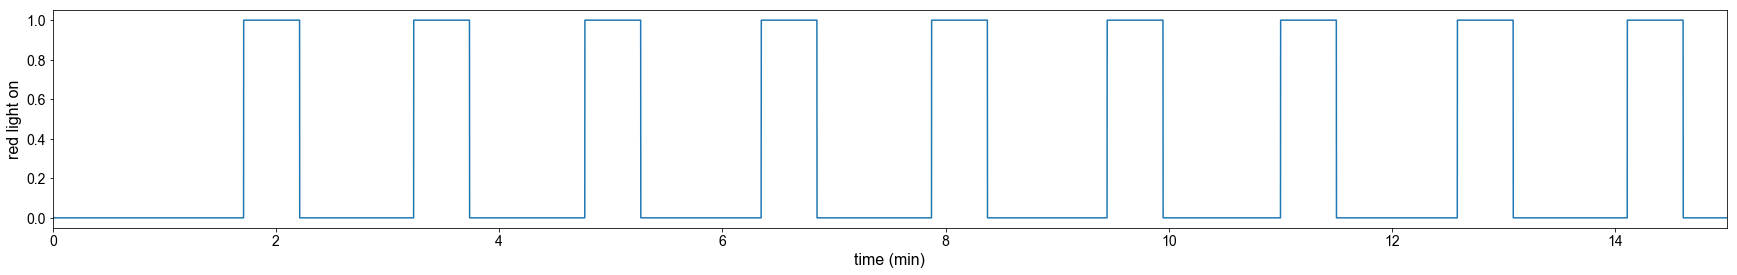

In [6]:
plt.figure(figsize=(30,4))
plt.plot(time_array, t_is_in_red)
#plt.scatter(time_array, t_is_in_red, c=c_red_on)
plt.xlim(0, 15)
plt.xlabel('time (min)')
plt.ylabel('red light on')
plt.show()

## set mm per px

In [7]:
centroid_array = raw_centroid_array

In [8]:
df_centroids = []
for i in range(nROI):
    minx = np.nanmin(centroid_array[:, 0, i])
    maxx = np.nanmax(centroid_array[:, 0, i])
    miny = np.nanmin(centroid_array[:, 1, i])
    maxy = np.nanmax(centroid_array[:, 1, i])
    df_centroids.append([i, minx, maxx, miny, maxy])
df_centroids = pd.DataFrame(df_centroids)
df_centroids.columns = ['roi', 'minx', 'maxx', 'miny', 'maxy']
df_centroids['xrange'] = df_centroids['maxx'] - df_centroids['minx']
df_centroids['yrange'] = df_centroids['maxy'] - df_centroids['miny']

C:\Users\dB\Anaconda3\envs\classifier\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: All-NaN slice encountered
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\dB\Anaconda3\envs\classifier\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: All-NaN slice encountered
  after removing the cwd from sys.path.
C:\Users\dB\Anaconda3\envs\classifier\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: All-NaN slice encountered
  """
C:\Users\dB\Anaconda3\envs\classifier\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: All-NaN slice encountered
  


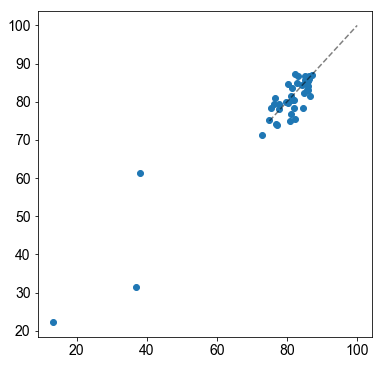

In [9]:
plt.figure(figsize=(6,6))
plt.scatter(df_centroids['xrange'], df_centroids['yrange'])
minn = 75
maxx = 100
plt.plot([minn, maxx], [minn, maxx], ls='--', alpha=0.5, c='k')
plt.show()

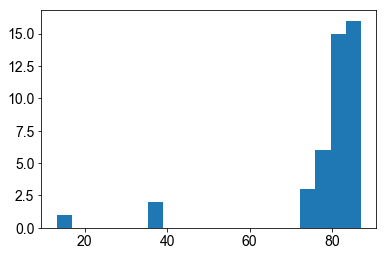

In [10]:
vs = df_centroids['xrange']
plt.figure()
plt.hist(vs[~np.isnan(vs)], bins=20)
plt.show()

In [11]:
arena_diam_in_mm = 28
median_margo_xrange = np.nanmedian(df_centroids['xrange'])
mm_per_pix = arena_diam_in_mm / median_margo_xrange

Convert speeds to mm/s:

In [12]:
def get_spd_from_centroids_bin(centroids, time_diffs):
    '''
    Given centroids data (n_frames * 2 * nROI),
    returns speed (n_frames * nROI) by computing 
    COM distance between two consecutive frames.
    '''
    # initialize with zeros
    spds = np.zeros(shape=(centroids.shape[0], centroids.shape[2]))
    # spd(i) = sqrt( [ (x(i) -x(i-1) ]^2 + [ (y(i) -y(i-1) ]^2 )
    px_diffs = np.sum(np.diff(centroids, axis=0)**2, axis=1)**(1/2)
    spds[1:, :] = (px_diffs.T / time_diffs[1:]).T
    # finally, fill NaN's with 0
    return np.nan_to_num(spds) 

In [13]:
speeds_px_s = get_spd_from_centroids_bin(raw_centroid_array, time_diff_array)
speeds_mm_s = speeds_px_s * mm_per_pix

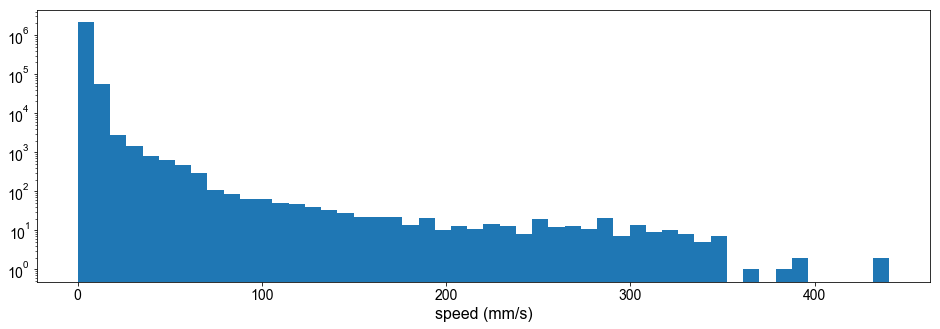

In [14]:
plt.figure(figsize=(16,5))
plt.hist(speeds_mm_s.flatten(), bins=50)
plt.semilogy()
plt.xlabel('speed (mm/s)')
plt.show()

In [15]:
speed_cutoff = 60

where_too_fast = np.where(speeds_mm_s > speed_cutoff)

centroid_array = raw_centroid_array.copy()
centroid_array[where_too_fast[0], :, where_too_fast[1]] = np.nan

speeds = get_spd_from_centroids_bin(centroid_array, time_diff_array)*mm_per_pix

print('discarded {} of {} points ({:.5f}%) for exceeding {} mm/s'.format(len(where_too_fast[0]), 
                                                               np.prod(centroid_array.shape), 
                                                               100*len(where_too_fast[0])/np.prod(centroid_array.shape),
                                                               speed_cutoff))

discarded 1216 of 4366752 points (0.02785%) for exceeding 60 mm/s


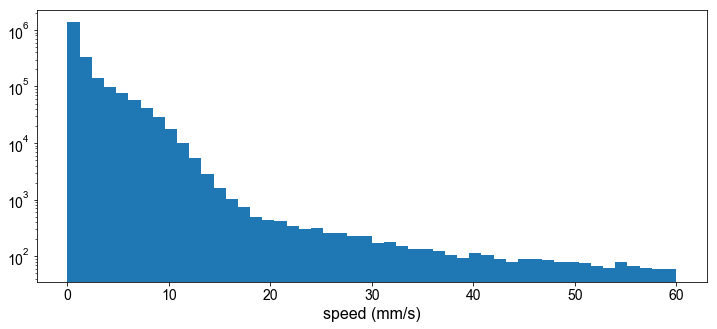

In [16]:
plt.figure(figsize=(12,5))
plt.hist(speeds.flatten(), bins=50)
plt.semilogy()
plt.xlabel('speed (mm/s)')
plt.show()

## plotting

In [17]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [18]:
plot_dir = 'optogenetics_pulsed_red'
   
SAVE_PLOTS = False

if SAVE_PLOTS:
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

C:\Users\dB\Anaconda3\envs\classifier\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
C:\Users\dB\Anaconda3\envs\classifier\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


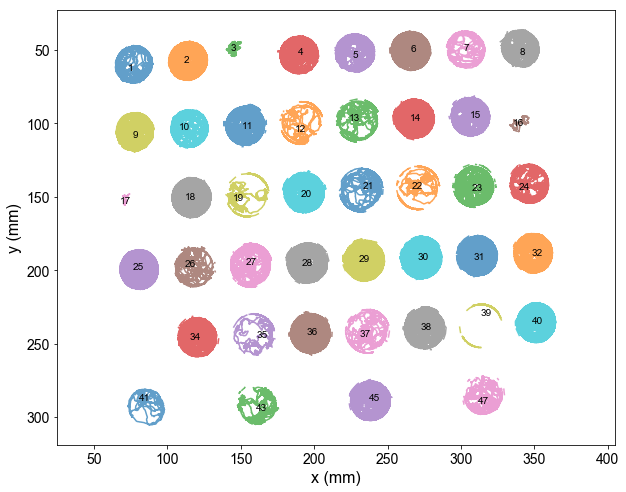

43 active ROIs out of 48


In [19]:
active_rois = []

plt.figure(figsize=(10,8))
for i in range(nROI):
    roi_x = np.nanmean(centroid_array[:, 0, i] * mm_per_pix)
    roi_y = np.nanmean(centroid_array[:, 1, i] * mm_per_pix)
    if not np.isnan(roi_x):
        plt.text(roi_x, roi_y, f'{i+1}', color='k', ha='center', va='center')
        active_rois.append(i)
    plt.plot(centroid_array[:, 0, i] * mm_per_pix, 
             centroid_array[:, 1, i] * mm_per_pix,
             alpha=0.7)
plt.axis('equal')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.gca().invert_yaxis()
if SAVE_PLOTS:
    plt.savefig(os.path.join(plot_dir, 'raw_traces.png'), bbox_inches='tight', facecolor='white')
#plt.xlim(25,75)
#plt.ylim(10,50)
plt.show()

active_rois = np.array(active_rois)
print('{} active ROIs out of {}'.format(len(active_rois), nROI))

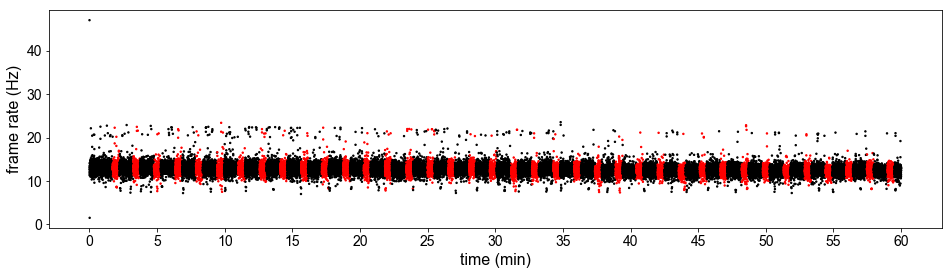

In [20]:
fig, axs = plt.subplots(1,1, figsize=(16,4))#, gridspec_kw={'width_ratios': [7, 2]})
axs.scatter(time_array, 1/time_diff_array, c=c_red_on, s=2, alpha=1)     
        
axs.set_xlabel('time (min)')
axs.set_ylabel('frame rate (Hz)')
#axs.set_ylim(0, 0.2)
axs.set_xticks(np.arange(min(time_array), max(time_array)+1, 5))
if SAVE_PLOTS:
    plt.savefig(os.path.join(plot_dir, 'frame_rate_thru_time.png'), facecolor='white', bbox_inches='tight', dpi=400)
plt.show()

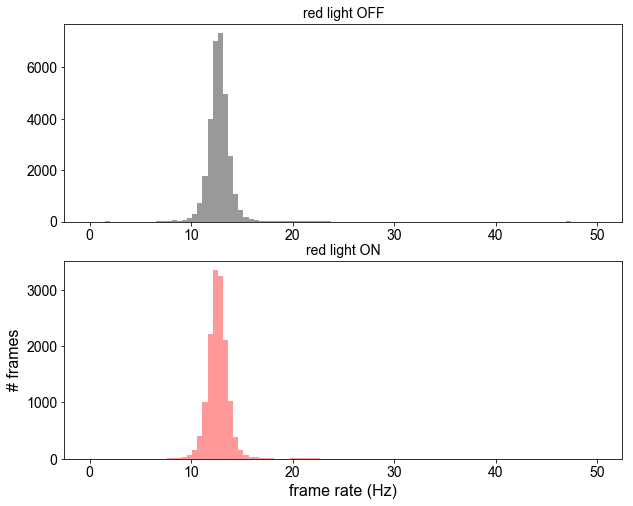

In [21]:
frs = 1/time_diff_array

xmin = 0
xmax = 50
nb = 100 
b = np.linspace(xmin, xmax, nb)

fig, axs = plt.subplots(2,1, figsize=(10,8))
axs[0].hist(frs[(t_is_in_red == 0)], color='k', bins=b, alpha=0.4)
axs[1].hist(frs[(t_is_in_red == 1)], color='red', bins=b, alpha=0.4)    

axs[0].set_title('red light OFF')
axs[1].set_title('red light ON')

axs[1].set_xlabel('frame rate (Hz)')
axs[1].set_ylabel('# frames')
if SAVE_PLOTS:
    plt.savefig(os.path.join(plot_dir, 'frame_rate.png'), facecolor='white', bbox_inches='tight', dpi=400)
plt.show()

C:\Users\dB\Anaconda3\envs\classifier\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: All-NaN slice encountered
  if __name__ == '__main__':


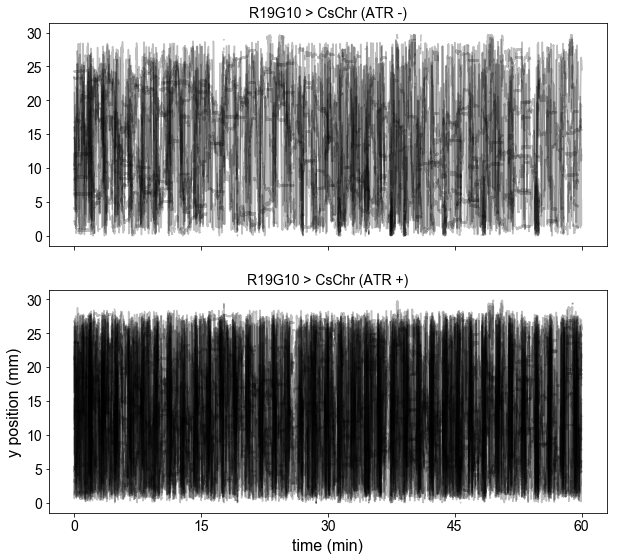

In [22]:
w = 1000
fig, axs = plt.subplots(2, 1, figsize=(10,9), sharex=True, sharey=True)
for i in range(nROI):
    ax = axs[i_to_cond(i)]
    
    xs = centroid_array[:, 0, i]*mm_per_pix
    ys = centroid_array[:, 1, i]*mm_per_pix
    
    ax.plot(time_array, ys-np.nanmin(ys), alpha=0.25, c='k')

for i in range(2):
    axs[i].set_title(cond_names[i])

plt.xlabel('time (min)')
plt.ylabel('y position (mm)')

plt.xticks(np.arange(min(time_array), max(time_array)+1, 15))

plt.show()

In [23]:
df_grand = []

for i_ROI in range(48):
    df_roi = pd.DataFrame()
    df_roi['speed'] = speeds[:, i_ROI]
    df_roi['red_stim'] = (t_is_in_red).astype(bool)
    df_roi['roi'] = i_ROI + 1
    df_roi['t'] = time_array
    df_roi['ATR_fed'] = i_ROI in ATR_plus_is
    df_grand.append(df_roi)
    
df_grand = pd.concat(df_grand).sort_values(['roi', 't'], ascending=[1,1])
df_grand = df_grand[df_grand.roi.isin(active_rois+1)]

df_grand['red_light'] = 'OFF'
df_grand.loc[df_grand['red_stim'], 'red_light'] = 'ON'
df_grand['food'] = 'ATR-'
df_grand.loc[df_grand['ATR_fed'], 'food'] = 'ATR+'

df_grand['log_speed'] = np.log10(df_grand['speed'])
df_grand.loc[~np.isfinite(df_grand['log_speed']), 'log_speed'] = np.nan

movement_thresh = 5
df_grand['is_walking'] = df_grand['speed'] >= movement_thresh

df_grand.head()

C:\Users\dB\Anaconda3\envs\classifier\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


speed  red_stim  roi         t  ATR_fed red_light  food  log_speed  \
0    0.0     False    1  0.000355    False       OFF  ATR-        NaN   
1    0.0     False    1  0.011243    False       OFF  ATR-        NaN   
2    0.0     False    1  0.012697    False       OFF  ATR-        NaN   
3    0.0     False    1  0.014175    False       OFF  ATR-        NaN   
4    0.0     False    1  0.015536    False       OFF  ATR-        NaN   

   is_walking  
0       False  
1       False  
2       False  
3       False  
4       False

In [24]:
on_to_off_time_min = time_array[IR_on_to_off_indices]
off_to_on_time_min = time_array[IR_off_to_on_indices]

stim_num_by_t = []
n_transitions = len(on_to_off_time_min)
cond_stats = []
cond_nums = []
for i in range(len(time_array)):
    cur_t = time_array[i]
    where_greater = np.where(cur_t > off_to_on_time_min)[0]
    which_onset = len(where_greater)
    stat = f'pre'#_{which_onset}'
    if which_onset >= n_transitions:
        stat = 'post'
    else:
        on_time = off_to_on_time_min[max(0, which_onset-1)]
        next_off_time = on_to_off_time_min[max(0, which_onset-1)]
        if which_onset < len(on_to_off_time_min):
            if (cur_t >= on_time) and (cur_t < next_off_time):
                stat = f'dur'#_{which_onset-1}'
    cond_stats.append(stat)
    cond_nums.append(which_onset)

df_timing = pd.DataFrame()
df_timing['t'] = time_array
df_timing['cond_stat'] = cond_stats
df_timing['cond_num'] = cond_nums

In [25]:
df_grand = df_grand.merge(df_timing, left_on='t', right_on='t')

In [26]:
df_cond = (df_grand
           .groupby(['food', 'cond_stat', 'cond_num'])
           .mean()#['speed']
           .reset_index()
           .sort_values(['food', 'cond_num', 'cond_stat'], ascending=[0, 1, 0])
           .reset_index(drop=True)
          )
df_cond.head()

food cond_stat  cond_num     speed  red_stim        roi         t  ATR_fed  \
0  ATR-       pre         0  1.684596  0.000000  19.736842  0.859386      0.0   
1  ATR-       dur         0  2.306426  1.000000  19.736842  1.710778      0.0   
2  ATR-       pre         1  1.142342  0.001267  19.736842  2.723786      0.0   
3  ATR-       dur         1  2.425319  1.000000  19.736842  1.962206      0.0   
4  ATR-       pre         2  1.196909  0.001247  19.736842  4.252541      0.0   

   log_speed  is_walking  
0   0.126902    0.079345  
1   0.260069    0.105263  
2   0.077569    0.032686  
3   0.290525    0.152290  
4   0.108174    0.043182

## speed distributions for ATR+/ATR- flies

(Figure 2-S2 E-F)

In [27]:
num_active_by_ATR_status = df_grand.groupby(['roi', 'ATR_fed']).count().reset_index()[['roi', 'ATR_fed']]['ATR_fed'].value_counts()
num_active_ATR_plus = num_active_by_ATR_status[True]
num_active_ATR_minus = num_active_by_ATR_status[False]

In [28]:
num_active_ATR_plus, num_active_ATR_minus

(24, 19)

In [29]:
df_grand2 = df_grand.copy()

df_grand2 = df_grand2#[df_grand2['speed'] >= 1]

df_no_ATR_dark = df_grand2[(df_grand2.food == 'ATR-') & (df_grand2.red_light == 'OFF')]
df_no_ATR_red = df_grand2[(df_grand2.food == 'ATR-') & (df_grand2.red_light == 'ON')]
df_ATR_dark = df_grand2[(df_grand2.food == 'ATR+') & (df_grand2.red_light == 'OFF')]
df_ATR_red = df_grand2[(df_grand2.food == 'ATR+') & (df_grand2.red_light == 'ON')]

df_conds = [
    df_no_ATR_dark,
    df_no_ATR_red,
    df_ATR_dark,
    df_ATR_red
]
cond_names = [
    'ATR - ; dark',
    'ATR - ; red',
    'ATR + ; dark',
    'ATR + ; red'
]
cond_colors = ['k', 'r', 'k', 'r']
cond_plot_axes = [0, 0, 1, 1]

It takes a very long time to compute the kdes. Set `compute_kdes` to `False` to read in a saved set of 1000 kdes to make the following plot.

In [30]:
compute_kdes = False

n_boot = 1000
xrange = np.linspace(-2, 2, 100)

if compute_kdes:
    all_cond_kde_vals = []
    for df_cond in df_conds:

        cond_rois = df_cond['roi'].unique()
        cond_fly_log_speeds = [df_cond.loc[df_cond.roi == r, 'log_speed'].values for r in cond_rois]

        n_cond_rois = len(cond_rois)

        cond_kdes = []
        cond_kde_vals = np.zeros((n_boot, len(xrange)))

        for bi in range(n_boot):
            bootstrap_rois = np.random.choice(np.arange(n_cond_rois), n_cond_rois, replace=True)
            bootstrap_log_speeds = np.concatenate([cond_fly_log_speeds[i] for i in bootstrap_rois])
            bootstrap_log_speeds = bootstrap_log_speeds[np.isfinite(bootstrap_log_speeds)]
            bootstrap_kde = gaussian_kde(bootstrap_log_speeds)
            cond_kdes.append(bootstrap_kde)
            cond_kde_vals[bi] = bootstrap_kde(xrange)

        all_cond_kde_vals.append(cond_kde_vals)
        # save 
        #pd.DataFrame(np.concatenate(all_cond_kde_vals), columns=xrange).to_csv('bootstrapped_kdes_pulsed_red.csv')
else:
    all_cond_kde_vals = pd.read_csv('bootstrapped_kdes_pulsed_red.csv', index_col=0)
    all_cond_kde_vals = all_cond_kde_vals.values
    all_cond_kde_vals = [all_cond_kde_vals[:1000],
                         all_cond_kde_vals[1000:2000],
                        all_cond_kde_vals[2000:3000],
                        all_cond_kde_vals[3000:4000]]

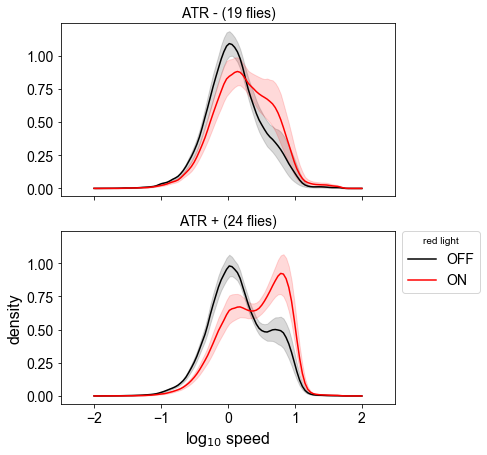

In [31]:
fig, axs = plt.subplots(2, 1, figsize=(6, 7), sharex=True, sharey=True, facecolor='white')

for i in range(4):
    plot_i = cond_plot_axes[i]
    cond_c = cond_colors[i]
    cond_kde_vals = all_cond_kde_vals[i]
    
    mean_kde = np.mean(cond_kde_vals, 0)
    kde_lower, kde_upper = np.percentile(cond_kde_vals, (5, 95), axis=0)
    
    lab = ''
    if i == 2: 
        lab = 'OFF'
    elif i == 3:
        lab = 'ON'
    axs[plot_i].fill_between(xrange, kde_lower, kde_upper, color=cond_c, alpha=0.15)
    axs[plot_i].plot(xrange, mean_kde, c=cond_c, label=lab)

axs[0].set_title('ATR - (19 flies)')
axs[1].set_title('ATR + (24 flies)')
plt.legend(title='red light', loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.xlabel(r'log$_{10}$ speed')
plt.ylabel('density')
plt.xlim(-2.5, 2.5)
#plt.savefig('kde_plot_bootstrap_CI_spd_all.png', bbox_inches='tight')
#plt.savefig('kde_plot_bootstrap_CI_spd_all.pdf', bbox_inches='tight')
plt.show()

## additional quantifications for ATR+/ATR- flies

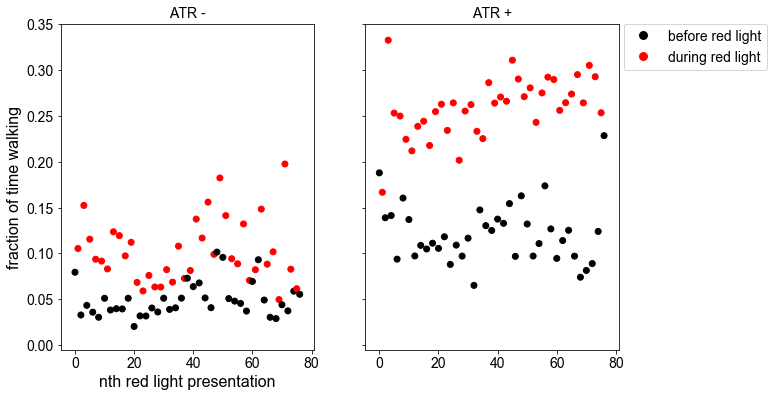

In [32]:
df_cond_ATR = df_cond[df_cond['food'] == 'ATR+']
df_cond_noATR = df_cond[df_cond['food'] == 'ATR-']

yvar = 'is_walking'
ylab = 'fraction of time walking'

fig, axs = plt.subplots(1, 2, figsize=(10,6), sharey=True, sharex=True, facecolor='white')

dark_red_alt = []
for i in range(len(df_cond_ATR)):
    colr = 'k' if i % 2 == 0 else 'r'
    dark_red_alt.append(colr)

axs[0].scatter(np.arange(len(df_cond_noATR)), df_cond_noATR[yvar], c=dark_red_alt)
axs[1].scatter(np.arange(len(df_cond_ATR)), df_cond_ATR[yvar], c=dark_red_alt)


pal = ['black', 'red']
plot_conds = ['before red light', 'during red light']
leg_elems = []
for i in range(2):
    
    leg_elems.append(Line2D([0], [0], marker='o', color='w', label=plot_conds[i],
                          markerfacecolor=pal[i], markersize=10))
    #Patch(facecolor=pal[i], edgecolor=pal[i], label=plot_conds[i]))
    
plt.legend(handles=leg_elems, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

axs[0].set_title('ATR -'); axs[1].set_title('ATR +')
axs[0].set_xlabel('nth red light presentation')
axs[0].set_ylabel(ylab)
plt.show()

In [33]:
df_res_mean = df_grand.groupby(['food', 'red_light']).mean()[['speed', 'is_walking']]
df_res_mean

speed  is_walking
food red_light                      
ATR+ OFF        1.963292    0.120293
     ON         3.291475    0.262398
ATR- OFF        1.147588    0.049336
     ON         1.855144    0.100407

In [34]:
df_res_sem = df_grand.groupby(['food', 'red_light']).sem()[['speed', 'is_walking']]
df_res_sem

speed  is_walking
food red_light                      
ATR+ OFF        0.003187    0.000376
     ON         0.006056    0.000749
ATR- OFF        0.003202    0.000282
     ON         0.006943    0.000575

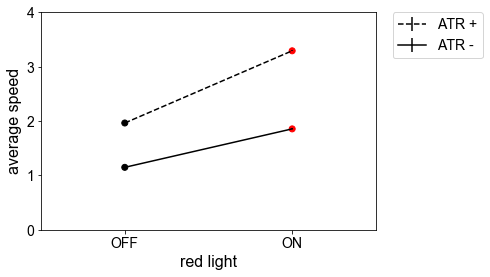

In [35]:
yvar = 'speed'
ylab = 'average speed'

plt.figure()
plt.scatter(x=['OFF', 'ON'], y=df_res_mean.loc['ATR+'][yvar], color=['k', 'r'], label='')
plt.errorbar(x=['OFF', 'ON'], y=df_res_mean.loc['ATR+'][yvar], yerr=df_res_sem.loc['ATR+'][yvar], 
             c='k', ls='--', label='ATR +')

plt.scatter(x=['OFF', 'ON'], y=df_res_mean.loc['ATR-'][yvar], color=['k', 'r'], label='')
plt.errorbar(x=['OFF', 'ON'], y=df_res_mean.loc['ATR-'][yvar], yerr=df_res_sem.loc['ATR-'][yvar], 
             c='k', ls='-', label='ATR -')

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)
plt.ylim(0, 4)
plt.xlim(-0.5, 1.5)
plt.ylabel(ylab)
plt.xlabel('red light')
plt.show()

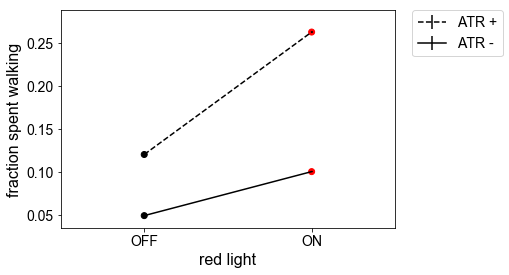

In [36]:
yvar = 'is_walking'
ylab = 'fraction spent walking'

plt.figure()
plt.scatter(x=['OFF', 'ON'], y=df_res_mean.loc['ATR+'][yvar], color=['k', 'r'], label='')
plt.errorbar(x=['OFF', 'ON'], y=df_res_mean.loc['ATR+'][yvar], yerr=df_res_sem.loc['ATR+'][yvar], 
             c='k', ls='--', label='ATR +')

plt.scatter(x=['OFF', 'ON'], y=df_res_mean.loc['ATR-'][yvar], color=['k', 'r'], label='')
plt.errorbar(x=['OFF', 'ON'], y=df_res_mean.loc['ATR-'][yvar], yerr=df_res_sem.loc['ATR-'][yvar], 
             c='k', ls='-', label='ATR -')

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)
#plt.ylim(0, 1)
plt.xlim(-0.5, 1.5)
plt.ylabel(ylab)
plt.xlabel('red light')
plt.show()

### single trial overlay

In [37]:
IR_off_to_on_times = time_array[IR_off_to_on_indices]
IR_on_to_off_times = time_array[IR_on_to_off_indices]

In [38]:
active_ATR_plus_is = np.intersect1d(ATR_plus_is, active_rois)
active_ATR_minus_is = np.intersect1d(ATR_minus_is, active_rois)

n_active_ATR_plus = len(active_ATR_plus_is)
n_active_ATR_minus = len(active_ATR_minus_is)

print(n_active_ATR_plus, n_active_ATR_minus)

24 19


In [39]:
wl = 100
alph = 0.5
xtick_width = 1

# just set explicit times
plot_xmin = 0
plot_xmax = 60

'''
# set relative to a trial
trial_index = -3
trial_time = IR_off_to_on_times[trial_index]
rel_xmin = -5
rel_xmax = 5
plot_xmin = trial_time + rel_xmin
plot_xmin -= plot_xmin % xtick_width
plot_xmax = trial_time + rel_xmax
'''

# get the time array
trial_indices = np.where((time_array >= plot_xmin) & # trial_time + rel_xmin) & 
                         (time_array <= plot_xmax))[0] # trial_time + rel_xmax))[0]
trial_times = time_array[trial_indices]
x_time = trial_times

# make the speeds / mean
ATR_trial_speeds = speeds[trial_indices, :][:, active_ATR_plus_is]
no_ATR_trial_speeds = speeds[trial_indices, :][:, active_ATR_minus_is]

ATR_trial_mean = pd.Series(np.mean(ATR_trial_speeds, 1)).rolling(wl, axis=0, center=True).mean()
no_ATR_trial_mean = pd.Series(np.mean(no_ATR_trial_speeds, 1)).rolling(wl, axis=0, center=True).mean()

ATR_trial_se = pd.Series(np.std(ATR_trial_speeds, 1) / np.sqrt(n_active_ATR_plus)).rolling(wl, axis=0, center=True).mean()
no_ATR_trial_se = pd.Series(np.std(no_ATR_trial_speeds, 1) / np.sqrt(n_active_ATR_minus)).rolling(wl, axis=0, center=True).mean()

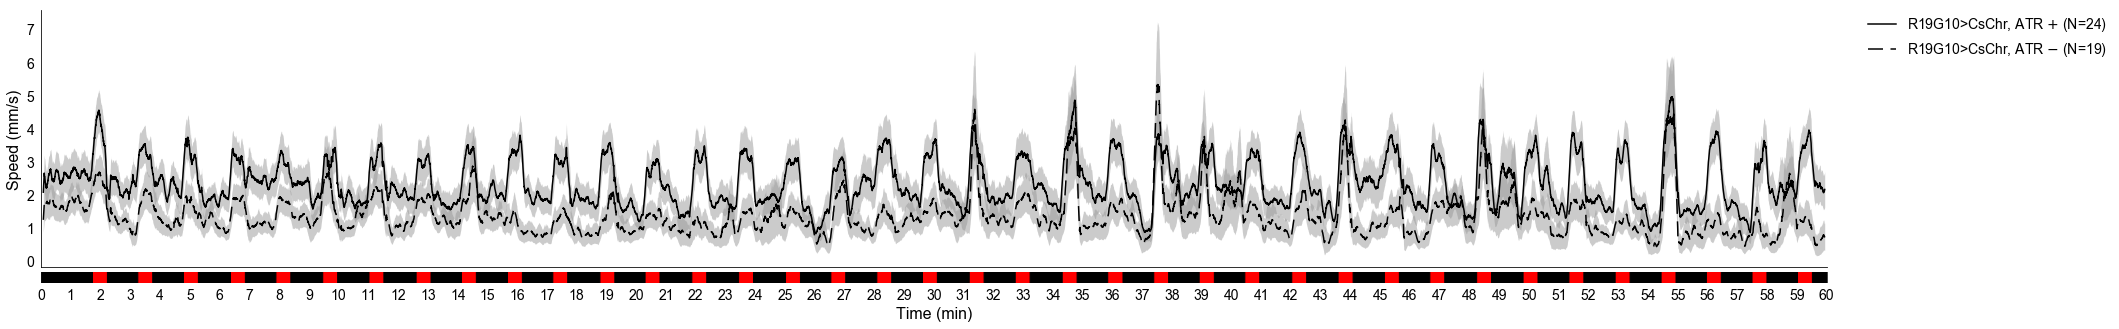

In [40]:
fig, axs = plt.subplots(2, 1, figsize=(32,5), sharex=True, gridspec_kw={'height_ratios': [25, 1]}, facecolor='white')

ax = axs[0]

# ATR +
ax.plot(x_time, ATR_trial_mean, 
        c='k', label=r'R19G10>CsChr, ATR $+$ (N={})'.format(n_active_ATR_plus))
ax.fill_between(x_time, 
                 ATR_trial_mean-ATR_trial_se,
                 ATR_trial_mean+ATR_trial_se, 
                 color='0.6', alpha=alph, lw=0)

# ATR -
ax.plot(x_time, no_ATR_trial_mean, 
        c='k', ls='--', label=r'R19G10>CsChr, ATR $-$ (N={})'.format(n_active_ATR_minus),
        dashes=[10,5])
ax.fill_between(x_time, 
                 no_ATR_trial_mean-no_ATR_trial_se,
                 no_ATR_trial_mean+no_ATR_trial_se, 
                 color='0.6', alpha=alph, lw=0)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0, frameon=False)
ax.set_ylabel('Speed (mm/s)')
ax.set_xticks([])
ax.yaxis.set_ticks_position('none') 
ax.xaxis.set_ticks_position('none') 

ax = axs[1]

#ax.plot(x_time, t_is_in_red[trial_indices])
ax.fill_between(x_time, t_is_in_red[trial_indices], color='r')
ax.fill_between(x_time, t_is_in_red[trial_indices], 1, color='k')
ax.set_ylim(0.2,0.8)

ax.set_xlim(plot_xmin, plot_xmax)
ax.set_xticks(np.arange(plot_xmin, plot_xmax+0.001, xtick_width))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.set_ticks_position('none') 
ax.set_yticks([])
ax.set_xlabel('Time (min)')

plt.subplots_adjust(hspace=0.03)

#plt.savefig(os.path.join(plot_dir, 'speed_overlay_whole_experiment.png'), facecolor='white', bbox_inches='tight', dpi=400)
plt.show()

In [41]:
num_trials = len(IR_off_to_on_times)

ATR_trial_mean_speeds = np.zeros(num_trials)
no_ATR_trial_mean_speeds = np.zeros(num_trials)

for i in range(num_trials):
    red_time_on = IR_off_to_on_times[i]
    red_time_off = IR_on_to_off_times[i]
    
    red_indices = np.where((time_array >= red_time_on) & (time_array <= red_time_off))[0]
    
    red_times = time_array[red_indices]
    
    ATR_trial_red_speeds = speeds[red_indices, :][:, active_ATR_plus_is]
    no_ATR_trial_red_speeds = speeds[red_indices, :][:, active_ATR_minus_is]
    
    ATR_trial_mean_speeds[i] = np.mean(ATR_trial_red_speeds)
    no_ATR_trial_mean_speeds[i] = np.mean(no_ATR_trial_red_speeds)

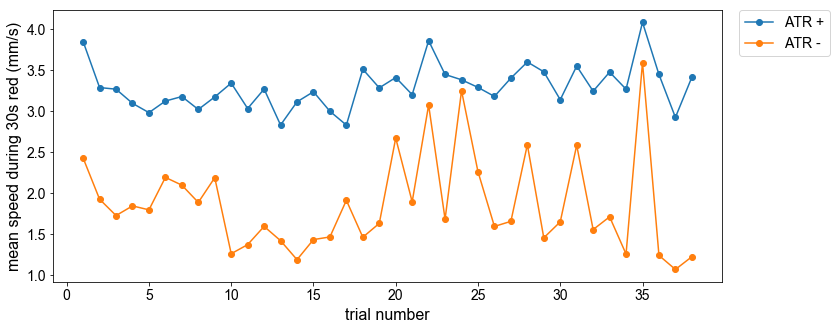

In [42]:
plt.figure(figsize=(12,5))
plt.plot(np.arange(num_trials) + 1, ATR_trial_mean_speeds, 'o-', label='ATR +')
plt.plot(np.arange(num_trials) + 1, no_ATR_trial_mean_speeds, 'o-', label='ATR -')
plt.xlabel('trial number')
plt.ylabel('mean speed during 30s red (mm/s)')
plt.legend(loc='upper left', bbox_to_anchor=(1.025, 1), borderaxespad=0)
#plt.savefig(os.path.join(plot_dir, 'mean_speed_by_trial_number.png'), facecolor='white', bbox_inches='tight', dpi=400)
plt.show()

### all trials overlay

In [43]:
t_min = -0.5
t_max = 1
t_delta = 0.01

t_range = np.arange(t_min, t_max+0.001, t_delta)
t_left_endpoints = t_range[:-1]
t_right_endpoints = t_range[1:]
t_midpoints = (t_left_endpoints + t_right_endpoints)/2
n_time_bins = len(t_midpoints)


num_trials = len(IR_off_to_on_times)

grand_ave_speeds_all_trials_all_flies = np.zeros((num_trials, n_time_bins, 48))
grand_sem_speeds_all_trials_all_flies = np.zeros((num_trials, n_time_bins, 48))
#grand_ave_speeds_all_trials_ATR_flies = np.zeros((num_trials, n_time_bins, len(active_ATR_plus_is)))
#grand_ave_speeds_all_trials_no_ATR_flies = np.zeros((num_trials, n_time_bins, len(active_ATR_minus_is)))

for trial_index in range(num_trials):

    trial_time = IR_off_to_on_times[trial_index]

    # get the time array
    og_trial_indices = np.where((time_array >= trial_time + t_min) & 
                                (time_array <= trial_time + t_max))[0]
    og_trial_times = time_array[og_trial_indices]

    og_trial_times_centered = og_trial_times - trial_time

    trial_speeds = speeds[og_trial_indices, :]
    
    trial_ave_speeds_all_animals = np.zeros((n_time_bins, 48))
    trial_sem_speeds_all_animals = np.zeros((n_time_bins, 48))

    for i in range(n_time_bins):
        cur_tbin_left = t_left_endpoints[i]
        cur_tbin_right = t_right_endpoints[i]

        cur_tbin_time_indices = np.where((og_trial_times_centered >= cur_tbin_left) & 
                                         (og_trial_times_centered < cur_tbin_right))[0]

        cur_tbin_speeds = trial_speeds[cur_tbin_time_indices, :]

        ave_tbin_speeds_per_animal = np.mean(cur_tbin_speeds, 0)

        trial_ave_speeds_all_animals[i, :] = ave_tbin_speeds_per_animal
        
        trial_sem_speeds_all_animals = np.std(cur_tbin_speeds, 0) / len(cur_tbin_speeds)
    
    
    grand_ave_speeds_all_trials_all_flies[trial_index, :, :] = trial_ave_speeds_all_animals
    grand_sem_speeds_all_trials_all_flies[trial_index, :, :] = trial_sem_speeds_all_animals
    #grand_ave_speeds_all_trials_ATR_flies[trial_index, :, :] = trial_ave_speeds_all_animals[:, ]
    #grand_ave_speeds_all_trials_no_ATR_flies[trial_index, :, :] = trial_ave_speeds_all_animals

In [44]:
wl = 1
grand_ATR_speeds = grand_ave_speeds_all_trials_all_flies[:, :, active_ATR_plus_is]
grand_no_ATR_speeds = grand_ave_speeds_all_trials_all_flies[:, :, active_ATR_minus_is]

ATR_trial_mean = np.mean(np.mean(grand_ATR_speeds, 0), 1)
no_ATR_trial_mean = np.mean(np.mean(grand_no_ATR_speeds, 0), 1)
rolling_ATR_trial_mean = pd.Series(ATR_trial_mean).rolling(wl, axis=0, center=True).mean()
rolling_no_ATR_trial_mean = pd.Series(no_ATR_trial_mean).rolling(wl, axis=0, center=True).mean()

#ATR_trial_std = np.std(np.std(grand_ATR_speeds, 0), 1)
#no_ATR_trial_std = np.std(np.std(grand_no_ATR_speeds, 0), 1)
#rolling_ATR_trial_se = pd.Series(ATR_trial_std / np.sqrt(n_active_ATR_plus*num_trials)).rolling(wl, axis=0, center=True).mean()
#rolling_no_ATR_trial_se = pd.Series(no_ATR_trial_std / np.sqrt(n_active_ATR_minus*num_trials)).rolling(wl, axis=0, center=True).mean()

ATR_trial_se = np.array([np.std(grand_ATR_speeds[:, i, :].flatten()) for i in range(n_time_bins)]) / np.sqrt(n_active_ATR_plus*num_trials)
no_ATR_trial_se = np.array([np.std(grand_no_ATR_speeds[:, i, :].flatten()) for i in range(n_time_bins)]) / np.sqrt(n_active_ATR_minus*num_trials)
rolling_ATR_trial_se = pd.Series(ATR_trial_se).rolling(wl, axis=0, center=True).mean()
rolling_no_ATR_trial_se = pd.Series(no_ATR_trial_se).rolling(wl, axis=0, center=True).mean()
'''
grand_ATR_SEM_speeds = grand_sem_speeds_all_trials_all_flies[:, :, active_ATR_plus_is]
grand_no_ATR_SEM_speeds = grand_sem_speeds_all_trials_all_flies[:, :, active_ATR_minus_is]

ATR_trial_sem = np.mean(np.mean(grand_ATR_SEM_speeds, 0), 1)
no_ATR_trial_sem = np.mean(np.mean(grand_no_ATR_SEM_speeds, 0), 1)
rolling_ATR_trial_se = pd.Series(ATR_trial_sem).rolling(wl, axis=0, center=True).mean()
rolling_no_ATR_trial_se = pd.Series(no_ATR_trial_sem).rolling(wl, axis=0, center=True).mean()
'''
None

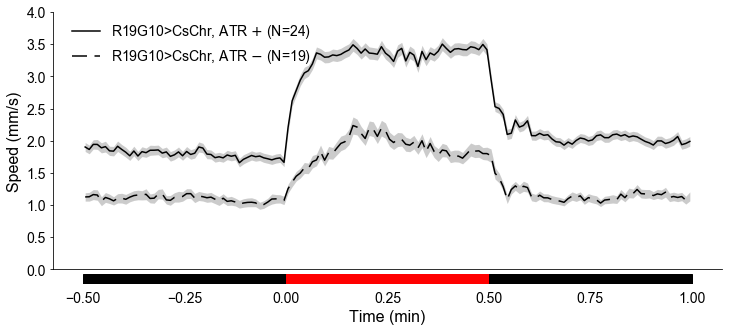

In [45]:
x_time = t_midpoints

fig, axs = plt.subplots(2, 1, figsize=(12,5), sharex=True, gridspec_kw={'height_ratios': [25, 1]}, facecolor='white')

ax = axs[0]

# ATR +
ax.plot(x_time, rolling_ATR_trial_mean,
        c='k', label=r'R19G10>CsChr, ATR $+$ (N={})'.format(n_active_ATR_plus))
ax.fill_between(x_time, 
                 rolling_ATR_trial_mean-rolling_ATR_trial_se,
                 rolling_ATR_trial_mean+rolling_ATR_trial_se, 
                 color='0.6', alpha=alph, lw=0)

# ATR -
ax.plot(x_time, rolling_no_ATR_trial_mean, 
        c='k', ls='--', label=r'R19G10>CsChr, ATR $-$ (N={})'.format(n_active_ATR_minus),
        dashes=[10,5])
ax.fill_between(x_time, 
                 rolling_no_ATR_trial_mean-rolling_no_ATR_trial_se,
                 rolling_no_ATR_trial_mean+rolling_no_ATR_trial_se, 
                 color='0.6', alpha=alph, lw=0)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98), borderaxespad=0, frameon=False)
ax.set_ylabel('Speed (mm/s)')
ax.set_ylim(0, 4)

#ax.set_xticks([])
#ax.yaxis.set_ticks_position('none') 
ax.xaxis.set_ticks_position('none') 

ax = axs[1]

ax.axvspan(t_min, 0, color='k')
ax.axvspan(0, 0.5, color='r')
ax.axvspan(0.5, t_max, color='k')
#ax.plot(x_time, t_is_in_red[trial_indices])
#ax.fill_between(x_time, t_is_in_red[trial_indices], color='r')
#ax.fill_between(x_time, t_is_in_red[trial_indices], 1, color='k')
#ax.set_ylim(0.2,0.8)

#ax.set_xlim(plot_xmin, plot_xmax)
ax.set_xticks(np.arange(t_min, t_max+0.001, 0.25))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.set_ticks_position('none') 
ax.set_yticks([])
ax.set_xlabel('Time (min)')

plt.subplots_adjust(hspace=0.03)

#plt.savefig(os.path.join(plot_dir, 'speed_overlay_collapse_trials.png'), facecolor='white', bbox_inches='tight', dpi=400)
plt.show()